In [1]:
import tensorflow as tf
import numpy as nps
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks
import pandas as pd
import os

2024-08-19 14:00:36.617645: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 14:00:36.617752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 14:00:36.744347: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# check CUDA
CUDA = torch.cuda.is_available()

device = torch.device('cuda' if CUDA else 'cpu')
print(device)

cuda


# Download the Dataset to the Working Space

In [3]:
!cp -r /kaggle/input/dogs-cats-images /kaggle/working/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


# AlexNet

In [4]:
def AlexNet():
    model = Sequential([
      # Convolution 1 with MaxPooling
      layers.Conv2D(input_shape=(227, 227 ,3), filters=96, kernel_size=(11, 11), strides=(4, 4)),
      layers.Activation('relu'),
      layers.BatchNormalization(),
      layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
      # Convolution 2 with MaxPooling
      layers.ZeroPadding2D(padding=(2, 2)),
      layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(3, 3)),
      layers.Activation('relu'),
      layers.BatchNormalization(),
      layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
      # Convolution 3
      layers.ZeroPadding2D(padding=(1, 1)),
      layers.Conv2D(filters=384, kernel_size=(3, 3)),
      layers.Activation('relu'),
      # Convolution 4
      layers.ZeroPadding2D(padding=(1, 1)),
      layers.Conv2D(filters=384, kernel_size=(3, 3)),
      layers.Activation('relu'),
      # Convolution 5
      layers.ZeroPadding2D(padding=(1, 1)),
      layers.Conv2D(filters=256, kernel_size=(3, 3)),
      layers.Activation('relu'),
      layers.BatchNormalization(),
      layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),

      layers.Flatten(),

      # Fully-Connected 1
      layers.Dense(4096, activation='relu', input_shape=6*6*128*2),
      layers.Dropout(0.5),
      layers.Dense(4096, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(2, activation='softmax'),
 ])
    
    # Add dynamic lr
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=100,
        decay_rate=0.9)
    
    model.summary()
    
    model.compile(optimizer=keras.optimizers.SGD(momentum=0.9, weight_decay=0.0005, learning_rate=lr_schedule), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

    return model

# Data Preprocesssing

In [5]:
train_dataset_path = '/kaggle/working/dogs-cats-images/dataset/training_set'
valid_dataset_path = '/kaggle/working/dogs-cats-images/dataset/test_set'


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    horizontal_flip=True,
)

validate_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=(227, 227),
    batch_size=256,
    shuffle=True,
    class_mode='categorical',
)

valid_datagenerator = validate_datagen.flow_from_directory(
    valid_dataset_path,
    target_size=(227, 227),
    batch_size=256,
    shuffle=False,
    class_mode='categorical',

)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# Training

In [6]:
model = AlexNet()

with tf.device('/GPU:0'):
    model_train = model.fit(
        train_generator,
        epochs=30,
        validation_data=valid_datagenerator
    )

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 55, 55, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 55, 55, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 31, 31, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 9, 9, 256)      │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 9, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 6, 6, 256)      │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 4, 4, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_2                │ (None, 6, 6, 384)      │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_3                │ (None, 6, 6, 384)      │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     1,052,67

 Total params: 21,591,810 (82.37 MB)

 Trainable params: 21,590,594 (82.36 MB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-08-19 14:04:08.630894: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[96,3,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,3,227,227]{3,2,1,0}, f32[256,96,55,55]{3,2,1,0}), window={size=11x11 stride=4x4}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-19 14:04:09.452491: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.821703268s
Trying algorithm eng0{} for conv (f32[96,

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.4961 - loss: 0.9442 

I0000 00:00:1724076257.819910      84 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724076257.844150      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14/32 ━━━━━━━━━━━━━━━━━━━━ 1:01 3s/step - accuracy: 0.5040 - loss: 0.8936

W0000 00:00:1724076302.444134      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5198 - loss: 0.8539

W0000 00:00:1724076340.665395      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.5207 - loss: 0.8521 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.5882 - loss: 0.7248 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.6396 - loss: 0.6407 - val_accuracy: 0.5000 - val_loss: 0.6957
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.6642 - loss: 0.6235 - val_accuracy: 0.5000 - val_loss: 0.6980
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.6894 - loss: 0.5996 - val_accuracy: 0.5000 - val_loss: 0.6998
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.7054 - loss: 0.5782 - val_accuracy: 0.5000 - val_loss: 0.6986
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.7273 - loss: 0.5453 - val_accuracy: 0.5000 - val_loss: 0.7042
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.7231 - loss: 0.5494 - val_accuracy: 0.4995 - val_loss: 0.

# Plot the Results

Minimum Validation Loss: 0.4136


<Axes: title={'center': 'Accuracy'}>

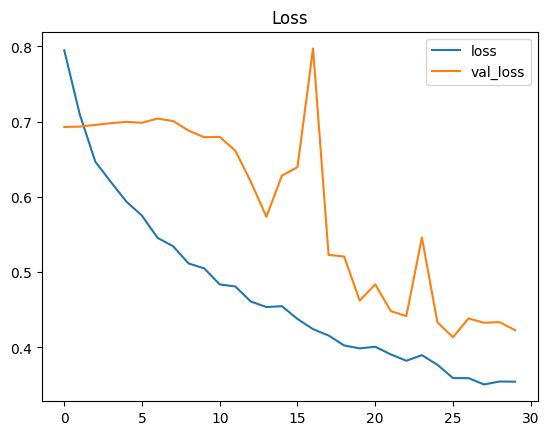

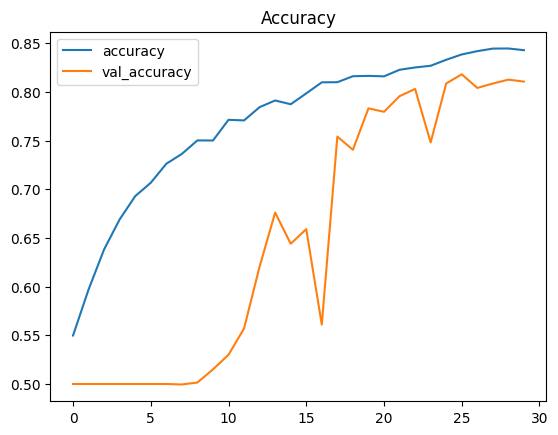

In [7]:
model_train_df = pd.DataFrame(model_train.history)

print("Minimum Validation Loss: {:0.4f}".format(model_train_df['val_loss'].min()))
model_train_df.loc[:, ['loss', 'val_loss']].plot(title='Loss')
model_train_df.loc[:, ['accuracy', 'val_accuracy']].plot(title='Accuracy')